# Libraries

In [1]:
import pickle
import pandas as pd
from os.path import exists
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

/var/folders/xt/y_17jz6n3p77v5p6cbm1tstr0000gn/T/ipykernel_23849/3887907873.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


# Loading the Files

Download the csv files into the `data/` directory.

## train.csv

1,697,533 unique reviews from Amazon Movie Reviews, with their associated star ratings and metadata. 
It is not necessary to use all reviews, or metadata for training. Some reviews will be missing a value in the 'Score' column. 
That is because, these are the scores you want to predict.

## test.csv

Contains a table with 212,192 unique reviews. 

The format of the table has two columns; 
- 'Id': contains an id that corresponds to a review in train.csv for which you predict a score 
- 'Score': the values for this column are missing since it will include the score predictions. 
- 
You are required to predict the star ratings of these Id using the metadata in train.csv.

## sample.csv 

a sample submission file. The 'Id' field is populated with values from test.csv. 
Kaggle will only evaluate submission files in this exact same format.

### Data fields:

- ProductId - unique identifier for the product
- UserId - unique identifier for the user
- HelpfulnessNumerator - number of users who found the review helpful
- HelpfulnessDenominator - number of users who indicated whether they found the review helpful
- Score - rating between 1 and 5
- Time - timestamp for the review
- Summary - brief summary of the review
- Text - text of the review
- Id - a unique identifier associated with a review

Note: Some of the rows of the table may have some of these values missing.

-ProductId - unique identifier for the product - duplicate 몇개 있는지 
-UserId - unique identifier for the user

# Preprocessing

# Adding Features

In [171]:
trainingSet = pd.read_csv("./data/train.csv") # Training Set
testingSet = pd.read_csv("./data/test.csv") # Testing Set

def add_features_to(df):
    # This is where you can do all your feature extraction

    df['Helpfulness'] = df['HelpfulnessNumerator'] / df['HelpfulnessDenominator'] # Helpfulness Feature
    df['Helpfulness'] = df['Helpfulness'].fillna(0)
    df.drop(columns=['HelpfulnessNumerator', 'HelpfulnessDenominator'], inplace=True)

    return df

# Load the feature extracted files if they've already been generated
if exists('./data/X_train.csv'):
    X_train = pd.read_csv("./data/X_train.csv")
if exists('./data/X_submission.csv'):
    X_submission = pd.read_csv("./data/X_submission.csv")

else:
    # Process the DataFrame
    train = add_features_to(trainingSet)

    # Merge on Id so that the submission set can have feature columns as well
    X_submission = pd.merge(train, testingSet, left_on='Id', right_on='Id')
    X_submission = X_submission.drop(columns=['Score_x'])
    X_submission = X_submission.rename(columns={'Score_y': 'Score'})

    # The training set is where the score is not null
    X_train =  train[train['Score'].notnull()]

    X_submission.to_csv("./data/X_submission.csv", index=False)
    X_train.to_csv("./data/X_train.csv", index=False)

In [132]:
print("X_train length is ", len(X_train))
print("X_submission length is ", len(X_submission))

X_train length is  1485341
X_submission length is  212192


In [162]:
n = 500000  # 원하는 행의 수
X_train = X_train.sample(n, random_state=42)

In [172]:
print("Now X_train length is ", len(X_train))
print("Now X_submission length is ", len(X_submission))

Now X_train length is  1485341
Now X_submission length is  212192


# Sample + Split into training and testing set

In [173]:
# Split Training Set into Training and Testing Set
X_train, X_test, Y_train, Y_test = train_test_split(
    X_train.drop(columns=['Score']),
    X_train['Score'],
    test_size=1/4.0,
    random_state=0
)

print("X_train shape is ", X_train.shape) # X_train Shape
print("X_test shape is ", X_test.shape) # X_test Shape
print("Y_train shape is ", Y_train.shape) # Y_train Shape
print("Y_test shape is ", Y_test.shape) # Y_test Shape

X_train shape is  (1114005, 7)
X_test shape is  (371336, 7)
Y_train shape is  (1114005,)
Y_test shape is  (371336,)


# Feature Selection

In [136]:
print(X_train.head())

              Id   ProductId          UserId        Time  \
578158   1490873  B005LAIIQC  A37L1OGFD7SB2I  1355875200   
249432   1149956  B0015LPS1Y   ARC10GZN44C34  1403568000   
1364280    24661  0780020693  A2NUD9S80DZRQG  1209945600   
441970    696595  B000063V8U  A2M2MUKWB2TRVL  1399766400   
906438    305805  6302287375  A338L6RMPYT3ZR  1333411200   

                                       Summary  \
578158                         nothing special   
249432                           love stargate   
1364280                 on the nostalgia wings   
441970   Part of one of the finest series ever   
906438             Love that but disappointed.   

                                                      Text  Helpfulness  
578158   some great moments, nice camera work and great...          0.0  
249432   We had been looking for this series for quite ...          0.0  
1364280  It's a sincere documentary of the era it depic...          0.0  
441970   It is simply brilliant.... well w

In [153]:
from collections import Counter
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

nltk.download('punkt')
nltk.download('stopwords')

def get_most_common_words(text_series, n=50):
    # 모든 텍스트를 하나의 문자열로 결합
    all_text = ' '.join(text_series.fillna('').astype(str))
    
    # 단어 토큰화
    words = word_tokenize(all_text.lower())
    
    # 불용어 제거
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word.isalnum() and word not in stop_words]
    
    # 가장 흔한 단어 n개 추출
    word_freq = Counter(words)
    return word_freq.most_common(n)

# X_train과 Y_train을 결합
df_combined = pd.concat([X_train, Y_train], axis=1)

# 각 등급별로 가장 흔한 단어 추출
for rating in sorted(df_combined['Score'].unique()):
    print(f"\n등급 {rating}에서 가장 흔한 단어 50개:")
    class_words = get_most_common_words(df_combined[df_combined['Score'] == rating]['Text'])
    for word, count in class_words:
        print(f"{word}: {count}")

# 등급 간 차이가 큰 단어 찾기
all_words = set()
class_word_freq = {}

for rating in sorted(df_combined['Score'].unique()):
    class_words = dict(get_most_common_words(df_combined[df_combined['Score'] == rating]['Text']))
    class_word_freq[rating] = class_words
    all_words.update(class_words.keys())

word_diff = {}
for word in all_words:
    freqs = [class_word_freq[rating].get(word, 0) for rating in sorted(df_combined['Score'].unique())]
    word_diff[word] = max(freqs) - min(freqs)

print("\n등급 간 빈도 차이가 가장 큰 단어 20개:")
for word, diff in sorted(word_diff.items(), key=lambda x: x[1], reverse=True)[:20]:
    print(f"{word}: {diff}")


[nltk_data] Downloading package punkt to /Users/jaylee/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/jaylee/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!



등급 1.0에서 가장 흔한 단어 50개:
movie: 6991
film: 3494
one: 3207
like: 2980
would: 2138
even: 1972
bad: 1776
time: 1657
good: 1617
could: 1501
really: 1482
get: 1481
see: 1375
story: 1259
movies: 1256
people: 1255
first: 1220
much: 1206
dvd: 1149
make: 1107
made: 1015
watch: 958
way: 955
never: 899
acting: 885
better: 885
know: 881
well: 860
think: 851
quot: 846
ever: 830
plot: 808
two: 801
characters: 796
nothing: 792
great: 780
character: 770
money: 755
seen: 743
watching: 742
show: 738
say: 723
many: 703
back: 692
something: 680
little: 679
want: 678
also: 677
films: 672
original: 654

등급 2.0에서 가장 흔한 단어 50개:
movie: 6869
film: 4945
one: 3709
like: 3206
good: 2399
would: 2337
really: 2048
even: 1932
story: 1821
much: 1798
get: 1623
time: 1564
see: 1514
could: 1511
first: 1403
bad: 1363
well: 1215
make: 1204
better: 1203
two: 1184
movies: 1149
way: 1143
character: 1130
great: 1129
characters: 1093
people: 1078
made: 1069
think: 1040
also: 1017
quot: 997
plot: 994
dvd: 990
little: 964
know: 946

KeyboardInterrupt: 

In [174]:
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import numpy as np
import nltk
from gensim.models import KeyedVectors, Word2Vec
from gensim.scripts.glove2word2vec import glove2word2vec

# import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('vader_lexicon')

stopwords = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
analyzer = SentimentIntensityAnalyzer()

# # GloVe Embeddings
# glove_path = 'glove.6B/glove.6B.300d.txt'
# glove_embeddings = load_glove_embeddings(glove_path)

def combine_embeddings(word, glove_model, custom_model, method='concat'):
    glove_vec = glove_model[word] if word in glove_model else np.zeros(300)
    custom_vec = custom_model.wv[word] if word in custom_model.wv else np.zeros(300)
    
    if method == 'concat':
        return np.concatenate([glove_vec, custom_vec])
    elif method == 'average':
        return (glove_vec + custom_vec) / 2
    elif method == 'weighted':
        return glove_vec * 0.6 + custom_vec * 0.4
    else:
        raise ValueError(f"Invalid method: {method}")

# text preprocessing
def preprocess_words(text):
    if isinstance(text, float):
        text = str(text)
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    words = word_tokenize(text)
    words = [lemmatizer.lemmatize(word) for word in words if word not in stopwords]
    return words

# sentence vector
def get_sentence_vector(sentence, glove_model, custom_model, method='concat'):
    words = preprocess_words(sentence)
    vectors = [combine_embeddings(word, glove_model, custom_model, method) for word in words]
    if not vectors:
        return np.zeros(600 if method == 'concat' else 300)
    vectors = np.array(vectors)
    return np.mean(vectors, axis=0)

# Vader Sentiment
def get_sentiment_score(sentence):
    if isinstance(sentence, float):
        sentence = str(sentence)
    preprocessed_sentence = ' '.join(preprocess_words(sentence))
    return analyzer.polarity_scores(preprocessed_sentence)['compound']

def preprocess_dataframe(df, text_column, summary_column, glove_model, custom_model, method='concat'):
    # Text Vector
    print("Preprocessing text...")
    df['text_vector'] = df['Text'].apply(lambda x: get_sentence_vector(x, glove_model, custom_model, method))
    
    # Vader Sentiment
    print("Preprocessing sentiment...")
    df['text_sentiment'] = df[text_column].apply(get_sentiment_score)
    df['summary_sentiment'] = df[summary_column].apply(get_sentiment_score)
    
    # Length
    print("Preprocessing length...")
    df['text_length'] = df[text_column].fillna('').apply(len)
    df['summary_length'] = df[summary_column].fillna('').apply(len)

    # Drop the original text and summary columns
    df = df.drop(columns=[text_column])
    print("Preprocessing complete")
    return df

glove_path = 'glove.6B/glove.6B.300d.txt'
word2vec_output_file = 'glove.6B/glove.6B.300d.word2vec.txt'
glove2word2vec(glove_path, word2vec_output_file)
glove_model = KeyedVectors.load_word2vec_format(word2vec_output_file, binary=False)

sentences = [preprocess_words(text) for text in X_train['Text']]
custom_model = Word2Vec(sentences, vector_size=300, window=5, min_count=1, workers=4)

# preprocessing
X_train = preprocess_dataframe(X_train, 'Text', 'Summary', glove_model, custom_model, method='average')
X_test = preprocess_dataframe(X_test, 'Text', 'Summary', glove_model, custom_model, method='average')
X_submission = preprocess_dataframe(X_submission, 'Text', 'Summary', glove_model, custom_model, method='average')

X_train.drop(columns=['ProductId', 'UserId'], inplace=True)
X_test.drop(columns=['ProductId', 'UserId'], inplace=True)
X_submission.drop(columns=['ProductId', 'UserId'], inplace=True)

[nltk_data] Downloading package punkt to /Users/jaylee/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/jaylee/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/jaylee/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/jaylee/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
/var/folders/xt/y_17jz6n3p77v5p6cbm1tstr0000gn/T/ipykernel_23849/1471932736.py:86: DeprecationWarning: Call to deprecated `glove2word2vec` (KeyedVectors.load_word2vec_format(.., binary=False, no_header=True) loads GLoVE text vectors.).
  glove2word2vec(glove_path, word2vec_output_file)


In [104]:
print(X_train.info())

<class 'pandas.core.frame.DataFrame'>
Index: 75000 entries, 578158 to 1119578
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Id              75000 non-null  int64  
 1   Time            75000 non-null  int64  
 2   Summary         74998 non-null  object 
 3   Helpfulness     75000 non-null  float64
 4   text_vector     75000 non-null  object 
 5   text_sentiment  75000 non-null  float64
 6   text_length     75000 non-null  int64  
 7   summary_length  75000 non-null  int64  
dtypes: float64(2), int64(4), object(2)
memory usage: 5.1+ MB
None


In [45]:
X_train.to_csv("./data/X_train_preprocessed.csv", index=False)
Y_train.to_csv("./data/Y_train_preprocessed.csv", index=False)
X_test.to_csv("./data/X_text_preprocessed.csv", index=False)
Y_test.to_csv("./data/Y_test_preprocessed.csv", index=False)
X_submission.to_csv("./data/X_submission_preprocessed.csv", index=False)

In [94]:
X_train = pd.read_csv("./data/X_train_preprocessed.csv")
Y_train = pd.read_csv("./data/Y_train_preprocessed.csv")
X_test = pd.read_csv("./data/X_text_preprocessed.csv")
Y_test = pd.read_csv("./data/Y_test_preprocessed.csv")
X_submission = pd.read_csv("./data/X_submission_preprocessed.csv")

# TF-IDF to Summary

In [168]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import scipy.sparse as sp

# TF-IDF 벡터라이저 초기화
tfidf = TfidfVectorizer(max_features=5000, stop_words='english', ngram_range=(1, 2))
count_vectorizer = CountVectorizer(ngram_range=(1, 2), max_features=5000, stop_words='english')

# 훈련 데이터 변환
summary_tfidf_train = tfidf.fit_transform(X_train['Summary'].fillna(''))
summary_tfidf_test = tfidf.transform(X_test['Summary'].fillna(''))
summary_tfidf_submission = tfidf.transform(X_submission['Summary'].fillna(''))

summary_count_train = count_vectorizer.fit_transform(X_train['Summary'].fillna(''))
summary_count_test = count_vectorizer.transform(X_test['Summary'].fillna(''))
summary_count_submission = count_vectorizer.transform(X_submission['Summary'].fillna(''))

numeric_features = ['text_sentiment', 'summary_sentiment', 'text_length', 'summary_length']

X_train_text_vector = np.vstack(X_train['text_vector'].values)
X_test_text_vector = np.vstack(X_test['text_vector'].values)
X_submission_text_vector = np.vstack(X_submission['text_vector'].values)

X_train_combined = sp.hstack([
    sp.csr_matrix(X_train_text_vector),
    summary_tfidf_train,
    summary_count_train,
    sp.csr_matrix(X_train[numeric_features].values)
])

X_test_combined = sp.hstack([
    sp.csr_matrix(X_test_text_vector),
    summary_tfidf_test,
    summary_count_test,
    sp.csr_matrix(X_test[numeric_features].values)
])  

X_submission_combined = sp.hstack([
    sp.csr_matrix(X_submission_text_vector),
    summary_tfidf_submission,
    summary_count_submission,
    sp.csr_matrix(X_submission[numeric_features].values)
])  


# Model Creation

In [169]:
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, make_scorer
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
Y_train_encoded = le.fit_transform(Y_train)

# Define XGBoost Model
model = xgb.XGBClassifier(
    objective='multi:softmax',
    booster='gbtree',
    num_class=5,
    learning_rate=0.1,
    max_depth=4,
    min_child_weight=3,
    n_estimators=1000,
    gamma=0.1,
    subsample=0.8,
    colsample_bytree=1.0,
    random_state=42
)

# Learn the model
model.fit(X_train_combined, Y_train_encoded)

# Predict the score using the model
Y_test_predictions = model.predict(X_test_combined)
y_pred = le.inverse_transform(Y_test_predictions)

# Model Evaluation
print("Accuracy on testing set = ", accuracy_score(Y_test, y_pred))
print("Classification Report: ", classification_report(Y_test, y_pred))
print("Confusion Matrix: ", confusion_matrix(Y_test, y_pred))


Accuracy on testing set =  0.635136
Classification Report:                precision    recall  f1-score   support

         1.0       0.59      0.54      0.56      7599
         2.0       0.39      0.22      0.28      7468
         3.0       0.47      0.28      0.35     14881
         4.0       0.46      0.32      0.38     28314
         5.0       0.71      0.90      0.79     66738

    accuracy                           0.64    125000
   macro avg       0.52      0.45      0.47    125000
weighted avg       0.60      0.64      0.60    125000

Confusion Matrix:  [[ 4073  1050   477   321  1678]
 [ 1385  1647  1689  1031  1716]
 [  633   991  4213  4280  4764]
 [  345   369  1939  9165 16496]
 [  471   189   651  5133 60294]]


In [167]:
# Create the submission file
Y_submission_predictions = model.predict(X_submission_combined)
X_submission['Score'] = le.inverse_transform(Y_submission_predictions)
submission = X_submission[['Id', 'Score']]
submission.to_csv("./data/submission.csv", index=False)

In [ ]:
import lightgbm as lgb



Score 분포:
Score
1.0     4646
2.0     4381
3.0     8713
4.0    16957
5.0    40303
Name: count, dtype: int64

가장 많이 나타나는 score: 5.0
해당 score의 개수: 40303
전체 대비 비율: 53.74%


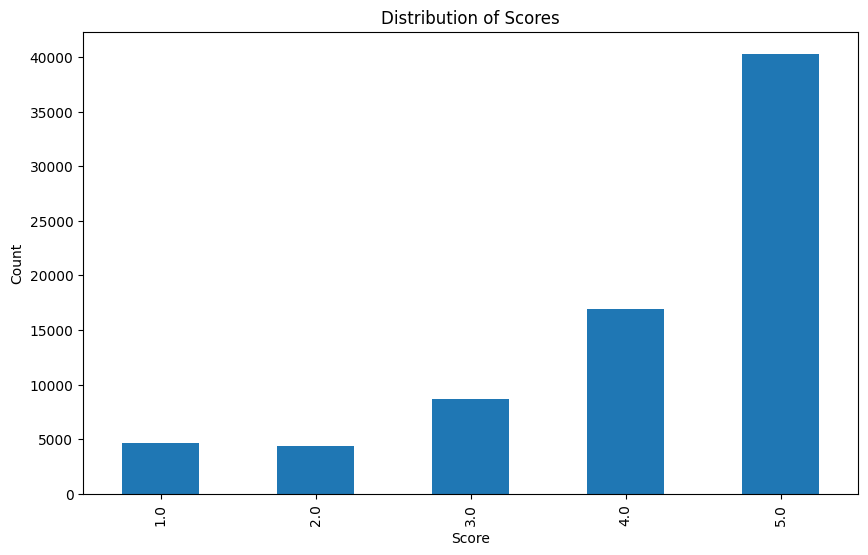

In [22]:
import pandas as pd
import matplotlib.pyplot as plt

# Y_train value counts
value_counts = Y_train.value_counts().sort_index()
print("Score 분포:")
print(value_counts)

# Most common score
most_common_score = value_counts.idxmax()
most_common_count = value_counts.max()
most_common_percentage = (most_common_count / len(Y_train)) * 100

print(f"\n가장 많이 나타나는 score: {most_common_score}")
print(f"해당 score의 개수: {most_common_count}")
print(f"전체 대비 비율: {most_common_percentage:.2f}%")

# Visualization
plt.figure(figsize=(10, 6))
value_counts.plot(kind='bar')
plt.title('Distribution of Scores')
plt.xlabel('Score')
plt.ylabel('Count')
plt.show()


In [170]:
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, make_scorer
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC

# Binary Classification
y_binary = (Y_train == 5.0).astype(int)

# Multi Classification for (1.0 ~ 4.0)
mask_multi = Y_train != 5.0
X_train_multi = X_train_combined[mask_multi]
Y_train_multi = Y_train[mask_multi]

binary_model = LogisticRegression(random_state=42, max_iter=10000)
binary_model.fit(X_train_combined, y_binary)

# binary_model = LinearSVC(random_state=42)
# binary_model.fit(X_train_combined, y_binary)

le = LabelEncoder()
Y_train_encoded = le.fit_transform(Y_train_multi)

multi_model = xgb.XGBClassifier(
    objective='multi:softmax',
    n_estimators=1000,
    max_depth=4,
    learning_rate=0.1,
    min_child_weight=3,
    gamma=0.1,
    subsample=0.8,
    colsample_bytree=1.0,
    num_class=4,
    enable_categorical=True,
    random_state=42)

multi_model.fit(
    X_train_multi, 
    Y_train_encoded)

def predict_hierarchical(Test_Data):
    binary_predictions = binary_model.predict(Test_Data)
    final_pred = np.full(binary_predictions.shape, 5.0)  # 5.0으로 초기화
    
    # 이진 예측이 0인 인덱스만 선택
    multi_indices = np.where(binary_predictions == 0)[0]
    
    if len(multi_indices) > 0:
        multi_predictions = multi_model.predict(Test_Data[multi_indices])
        multi_predictions = le.inverse_transform(multi_predictions)
        final_pred[multi_indices] = multi_predictions
    
    return final_pred

y_pred = predict_hierarchical(X_test_combined)
accuracy = accuracy_score(Y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(Y_test, y_pred))

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy: 0.6097

Classification Report:
              precision    recall  f1-score   support

         1.0       0.53      0.54      0.53      7599
         2.0       0.40      0.15      0.22      7468
         3.0       0.43      0.24      0.31     14881
         4.0       0.37      0.50      0.43     28314
         5.0       0.78      0.80      0.79     66738

    accuracy                           0.61    125000
   macro avg       0.50      0.44      0.46    125000
weighted avg       0.61      0.61      0.60    125000



In [61]:
X_submission['Score'] = predict_hierarchical(X_submission_combined)
submission = X_submission[['Id', 'Score']]
submission.to_csv("./data/submission.csv", index=False)

# Parameter Tuning

In [52]:
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, make_scorer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV

# Label Encoding
le = LabelEncoder()
Y_train_encoded = le.fit_transform(Y_train)
Y_test_encoded = le.transform(Y_test)

# Define XGBoost Model
model = xgb.XGBClassifier(
    objective='multi:softmax',
    booster='gbtree',
    num_class=5,
    learning_rate=0.1,
    n_estimators=100,
    max_depth=7,
    min_child_weight=3,
    gamma=0.1,
    subsample=0.8,
    colsample_bytree=1.0,
    random_state=42
)

param_test1 = {
    'n_estimators': [100, 200, 300, 400, 500]
}

grid_search = GridSearchCV(
    estimator=model, 
    param_grid=param_test1,
    cv=5,
    scoring='accuracy'
)

grid_search.fit(X_train_combined, Y_train_encoded)

print("Best Parameters: ", grid_search.best_params_)
print("Best Score: ", grid_search.best_score_)


KeyboardInterrupt: 

In [51]:
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, make_scorer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV

# Label Encoding
le = LabelEncoder()
Y_train_encoded = le.fit_transform(Y_train)
Y_test_encoded = le.transform(Y_test)

# Define XGBoost Model
model = xgb.XGBClassifier(
    objective='multi:softmax',
    learning_rate=0.1,
    n_estimators=100,
    gamma=0,
    subsample=0.8,
    colsample_bytree=0.8,
    num_class=5,
    booster='gbtree',
    random_state=42
)

param_test1 = {
    'max_depth': [6, 7, 8],
    'min_child_weight': [2, 3, 4]
}

grid_search = GridSearchCV(
    estimator=model, 
    param_grid=param_test1,
    cv=5,
    scoring='accuracy'
)

grid_search.fit(X_train_combined, Y_train_encoded)

print("Best Parameters: ", grid_search.best_params_)
print("Best Score: ", grid_search.best_score_)


Best Parameters:  {'max_depth': 8, 'min_child_weight': 4}
Best Score:  0.60568


# SVC

In [34]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

rf = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
svc = SVC(kernel='rbf', C=1, gamma='auto', random_state=42)

# Train Random Forest
print("Training Random Forest...")
rf.fit(X_train_combined, Y_train)

# Train SVC
print("Training SVC...")
svc.fit(X_train_combined, Y_train)

# Make predictions
rf_predictions = rf.predict(X_test_combined)
svc_predictions = svc.predict(X_test_combined)

# Evaluate models
print("Random Forest Accuracy:", accuracy_score(Y_test, rf_predictions))
print("SVC Accuracy:", accuracy_score(Y_test, svc_predictions))

print("\nRandom Forest Classification Report:")
print(classification_report(Y_test, rf_predictions))

print("\nSVC Classification Report:")
print(classification_report(Y_test, svc_predictions))

# Make predictions on the submission set
rf_submission_predictions = rf.predict(X_submission_combined)
svc_submission_predictions = svc.predict(X_submission_combined)

# If you need to save the predictions
X_submission['RF_Predictions'] = rf_submission_predictions
X_submission['SVC_Predictions'] = svc_submission_predictions

Training Random Forest...
Training SVC...
Random Forest Accuracy: 0.54804
SVC Accuracy: 0.55704

Random Forest Classification Report:
              precision    recall  f1-score   support

         1.0       0.63      0.16      0.25      1558
         2.0       0.00      0.00      0.00      1409
         3.0       0.39      0.00      0.01      3012
         4.0       0.26      0.01      0.03      5629
         5.0       0.55      1.00      0.71     13392

    accuracy                           0.55     25000
   macro avg       0.37      0.23      0.20     25000
weighted avg       0.44      0.55      0.40     25000


SVC Classification Report:
              precision    recall  f1-score   support

         1.0       0.48      0.40      0.44      1558
         2.0       0.50      0.00      0.01      1409
         3.0       0.89      0.00      0.01      3012
         4.0       0.00      0.00      0.00      5629
         5.0       0.56      0.99      0.72     13392

    accuracy           

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

# Model Evaluation

Accuracy on testing set =  0.40914607435494177


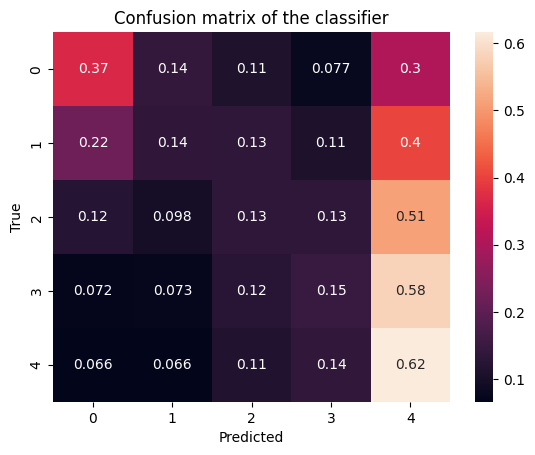

In [21]:
# Evaluate your model on the testing set
print("Accuracy on testing set = ", accuracy_score(Y_test, Y_test_predictions))

# Plot a confusion matrix
cm = confusion_matrix(Y_test, Y_test_predictions, normalize='true')
sns.heatmap(cm, annot=True)
plt.title('Confusion matrix of the classifier')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Create submission file

In [16]:
# Create the submission file
Y_submission_predictions = model.predict(X_submission_combined)
X_submission['Score'] = le.inverse_transform(Y_submission_predictions)
submission = X_submission[['Id', 'Score']]
submission.to_csv("./data/submission.csv", index=False)

In [23]:
# Create the submission file
X_submission['Score'] = model.predict(X_submission_select)
submission = X_submission[['Id', 'Score']]
submission.to_csv("./data/submission.csv", index=False)